# Multi-Class Classification on "Hardware" Category

## 1. Imports

In [1]:
import ast
import random
import re
import string
from collections import Counter
from pathlib import Path
from typing import Any, Union

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from matplotlib import pyplot as plt
from numpy import asarray
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from wordcloud import WordCloud

from preprocess_functions import build_tree, extract_keys, map_targets
from utils import CalibratedLabelRankClassifier, ChainOfClassifiers, LabelPowersetClassifier, \
    assess_models, prune_and_subsample, ConditionalDependencyNetwork, MetaBinaryRelevance, replace_text_components, \
    clean_text, lemmatize_text, remove_stopwords, tokenizer_transform

[nltk_data] Downloading package punkt to /home/cela/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cela/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cela/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/cela/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-05 12:22:59.616427: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow 

## 2. Configurations & Constants

### Global Configuration Constants

In [2]:
OVERWRITE = True
RETRAIN = True
RANDOM_STATE = 42
MODEL_LEVEL = 'hardware'

### Set Random Seeds

In [3]:
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

### Testing Parameters

In [4]:
TEST_SIZE = 2e-1

### Category Mappings

In [5]:
FIX_TARGETS = {
    'computer': 'computer',
    'computer components': 'computer components',
    'computer networking': 'computer networking'
}

### Base Models

In [6]:
BASE_CLASSIFIERS = {
    'logistic_regression': LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight='balanced'),
    #'gaussian_nb': GaussianNB(),
    #'decision_tree': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'random_forest': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'xgb': xgb.XGBClassifier(random_state=RANDOM_STATE),
}

### Directory Paths

In [7]:
COLAB_DIR = Path('/content/drive/MyDrive')
KAGGLE_DIR = Path('/kaggle/input')
LOCAL_DIR = Path('./')

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import kaggle_secrets

    IN_KAGGLE = True
except ImportError:
    IN_KAGGLE = False

if IN_COLAB:
    DATA_DIR = COLAB_DIR / 'data'
    MODELS_DIR = COLAB_DIR / 'models'
elif IN_KAGGLE:
    DATA_DIR = KAGGLE_DIR
    MODELS_DIR = KAGGLE_DIR
else:
    DATA_DIR = LOCAL_DIR / 'data'
    MODELS_DIR = LOCAL_DIR / 'models'

### Dataset & Model Paths

In [8]:
BINARY_PROBLEMS_DIR = MODELS_DIR / 'binary_problems'
ENSEMBLES_DIR = MODELS_DIR / 'ensembles'
MULTICLASS_PROBLEMS_DIR = MODELS_DIR / 'multiclass_problems'
GLOVE_DIR = MODELS_DIR / 'glove-embeddings'
GLOVE_6B_300D_TXT = GLOVE_DIR / 'glove.6B.300d.txt'

DATASET_DIR = DATA_DIR / 'tweets-dataset-for-cyberattack-detection'
THREAT_TWEETS_CSV = DATASET_DIR / 'tweets_train.csv'

HARDWARE_PKL = MODELS_DIR / f'{MODEL_LEVEL}.pkl'
BR_PKL = BINARY_PROBLEMS_DIR / f'br_{MODEL_LEVEL}.pkl'
CLR_PKL = BINARY_PROBLEMS_DIR / f'clr_{MODEL_LEVEL}.pkl'
CC_PKL = BINARY_PROBLEMS_DIR / f'cc_{MODEL_LEVEL}.pkl'

LP_PKL = MULTICLASS_PROBLEMS_DIR / f'lp_{MODEL_LEVEL}.pkl'
PST_PKL = MULTICLASS_PROBLEMS_DIR / f'pst_{MODEL_LEVEL}.pkl'

CDN_PKL = ENSEMBLES_DIR / f'pkl_{MODEL_LEVEL}.pkl'
MBR_PKL = ENSEMBLES_DIR / f'mbr_{MODEL_LEVEL}.pkl'

### Loading Models

In [9]:
br = joblib.load(filename=BR_PKL) if BR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
clr = joblib.load(filename=CLR_PKL) if CLR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cc = joblib.load(filename=CC_PKL) if CC_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
lp = joblib.load(filename=LP_PKL) if LP_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
pst = joblib.load(filename=PST_PKL) if PST_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cdn = joblib.load(filename=CDN_PKL) if CDN_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
mbr = joblib.load(filename=MBR_PKL) if MBR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)

## 3. Data Loading & Preprocessing

Load the dataset, inspect its structure, and preprocess it for machine learning models.
For the goal of the project, the categories of interest for the category 'computer security' are:
1. computer
2. computer components
3. computer networking

In [10]:
threat_tweets = (
    pd.read_csv(filepath_or_buffer=THREAT_TWEETS_CSV)
    .assign(
        tweet=lambda df: df['tweet'].apply(func=ast.literal_eval),
        watson=lambda df: df['watson'].apply(func=ast.literal_eval)
        .apply(func=lambda x: x.get('categories', []))
        .apply(func=build_tree),
        watson_list=lambda df: df['watson'].apply(func=extract_keys),
        target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_TARGETS,))
    )
    .query(expr='relevant == True')
    .drop(labels=[
        'relevant', '_id', 'date',
        'id', 'tweet', 'type',
        'annotation', 'urls', 'destination_url',
        'valid_certificate'
    ], axis=1)
    .dropna(subset=['text'], ignore_index=True)
)
threat_tweets['text'] = [replace_text_components(t) for t in threat_tweets['text']]
threat_tweets['text'] = [clean_text(t) for t in threat_tweets['text']]
threat_tweets['text'] = [lemmatize_text(t) for t in threat_tweets['text']]
threat_tweets['text'] = [remove_stopwords(t) for t in threat_tweets['text']]

threat_tweets = threat_tweets[
    threat_tweets["watson_list"].apply(lambda x: ' '.join(MODEL_LEVEL.split(sep='_')) in x)
].reset_index(drop=True)

print(f"Threat Tweets: {len(threat_tweets)}")
threat_tweets.head()

Threat Tweets: 1741


,text,watson,watson_list,target
0,bruteforce flag via,{'technology and computing': {'software': {'da...,"[technology and computing, software, databases...",[computer]
1,another patch apache strut vulnerability exploit,{'technology and computing': {'programming lan...,"[technology and computing, programming languag...",[computer]
2,eoeo virus removal restore infected computer e...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[computer]
3,im gon na go curl ball cry guess,{'art and entertainment': {'movies and tv': {'...,"[art and entertainment, movies and tv, movies,...",[computer]
4,late version rtac3200 router disable feature i...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[computer networking]


## 4. Exploratory Data Analysis (EDA)
Here are uncovered patterns, relationships, and potential issues in the data that could impact model performances.

### 4.1. Text Analysis
The `text` attribute is examined using word frequency analysis, word clouds, and text length distribution.
It helps in identifying common words, potential stopwords, and variations in text length that may impact feature engineering.

#### 4.1.1. Word Frequency

In [11]:
all_words = ' '.join(threat_tweets['text']).split()
word_freq = Counter(all_words)
print("Top 10 Most Frequent Words:", word_freq.most_common(10))

Top 10 Most Frequent Words: [('vulnerability', 627), ('android', 265), ('find', 250), ('phone', 223), ('major', 215), ('manufacturer', 211), ('attack', 190), ('ransomware', 166), ('ddos', 159), ('remote', 133)]


#### 4.1.2. Word Cloud

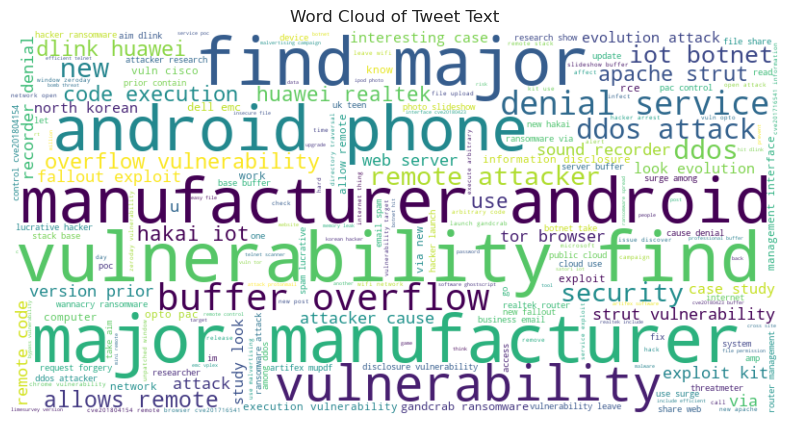

In [12]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text=' '.join(threat_tweets['text']))

plt.figure(figsize=(15, 5))
plt.imshow(X=wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()

#### 4.1.3. Text Length Distribution

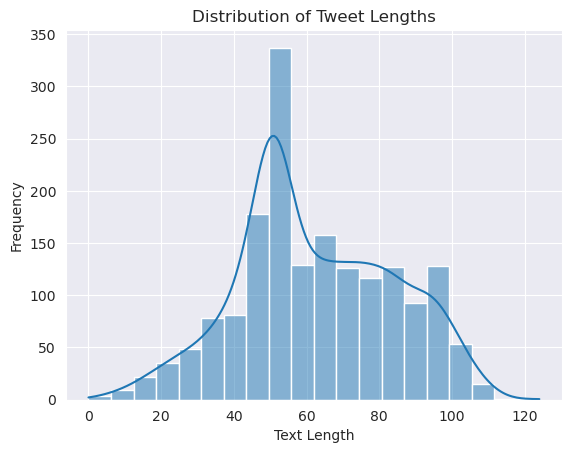

In [13]:
threat_tweets['text_length'] = threat_tweets['text'].apply(func=len)
sns.histplot(
    data=threat_tweets['text_length'],
    bins=20,
    kde=True
)
plt.title(label='Distribution of Tweet Lengths')
plt.xlabel(xlabel='Text Length')
plt.ylabel(ylabel='Frequency')
plt.show()

### 4.3. Watson List Analysis
In the `watson_list` attribute, it is performed category depth, co-occurrence patterns, and top-level category distribution analyses.

In [14]:
# Flatten watson_list and count category frequencies
all_categories = [category for sublist in threat_tweets['watson_list'] for category in sublist]
category_freq = Counter(all_categories)
print("Top 10 Most Frequent Categories:", category_freq.most_common(n=10))

Top 10 Most Frequent Categories: [('technology and computing', 1741), ('hardware', 1741), ('computer', 1375), ('computer security', 736), ('software', 637), ('antivirus and malware', 603), ('consumer electronics', 326), ('telephones', 280), ('mobile phones', 279), ('smart phones', 268)]


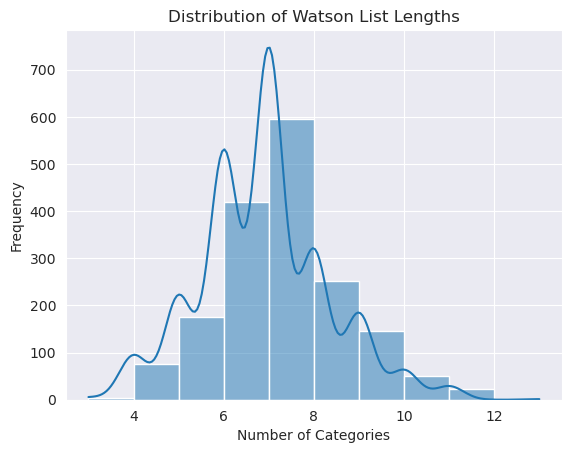

In [15]:
# Category Depth Analysis
threat_tweets['watson_list_length'] = threat_tweets['watson_list'].apply(func=len)

sns.histplot(
    data=threat_tweets['watson_list_length'],
    bins=10,
    kde=True
)

plt.title(label='Distribution of Watson List Lengths')
plt.xlabel(xlabel='Number of Categories')
plt.ylabel(ylabel='Frequency')
plt.show()

In [16]:
# Create co-occurrence matrix
co_occurrence = Counter()
for categories in threat_tweets['watson_list']:
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            co_occurrence[(categories[i], categories[j])] += 1

print("Top 10 Co-occurring Category Pairs:", co_occurrence.most_common(n=10))

Top 10 Co-occurring Category Pairs: [(('technology and computing', 'hardware'), 1741), (('technology and computing', 'computer'), 1375), (('hardware', 'computer'), 1375), (('technology and computing', 'computer security'), 736), (('technology and computing', 'software'), 637), (('technology and computing', 'antivirus and malware'), 603), (('computer security', 'antivirus and malware'), 603), (('computer security', 'hardware'), 584), (('computer security', 'computer'), 521), (('antivirus and malware', 'hardware'), 516)]


In [17]:
# Top-Level Category Distribution
top_level_categories = [category.split()[0] for category in all_categories]
top_level_freq = Counter(top_level_categories)
print("Top-Level Category Frequencies:", top_level_freq.most_common())

Top-Level Category Frequencies: [('computer', 2618), ('technology', 1741), ('hardware', 1741), ('software', 637), ('antivirus', 603), ('consumer', 327), ('telephones', 280), ('mobile', 279), ('smart', 268), ('router', 210), ('network', 166), ('operating', 142), ('databases', 136), ('networking', 113), ('business', 113), ('vpn', 109), ('programming', 102), ('portable', 87), ('disks', 76), ('law,', 70), ('linux', 69), ('society', 64), ('servers', 60), ('home', 57), ('javascript', 54), ('health', 53), ('art', 53), ('science', 50), ('printers,', 47), ('laptop', 46), ('crime', 42), ('personal', 38), ('government', 37), ('java', 37), ('motherboards', 36), ('internet', 34), ('graphics', 28), ('finance', 28), ('company', 27), ('sports', 26), ('mp3', 26), ('scanners', 26), ('memory', 25), ('disease', 24), ('weather', 24), ('merger', 22), ('meteorological', 22), ('unix', 21), ('email', 20), ('plumbing', 20), ('addiction', 20), ('alcoholism', 20), ('hobbies', 19), ('windows', 19), ('printers', 19

### 4.4. Target Analysis

Target Frequencies:
computer: 1320
computer networking: 220
computer components: 140
other: 61


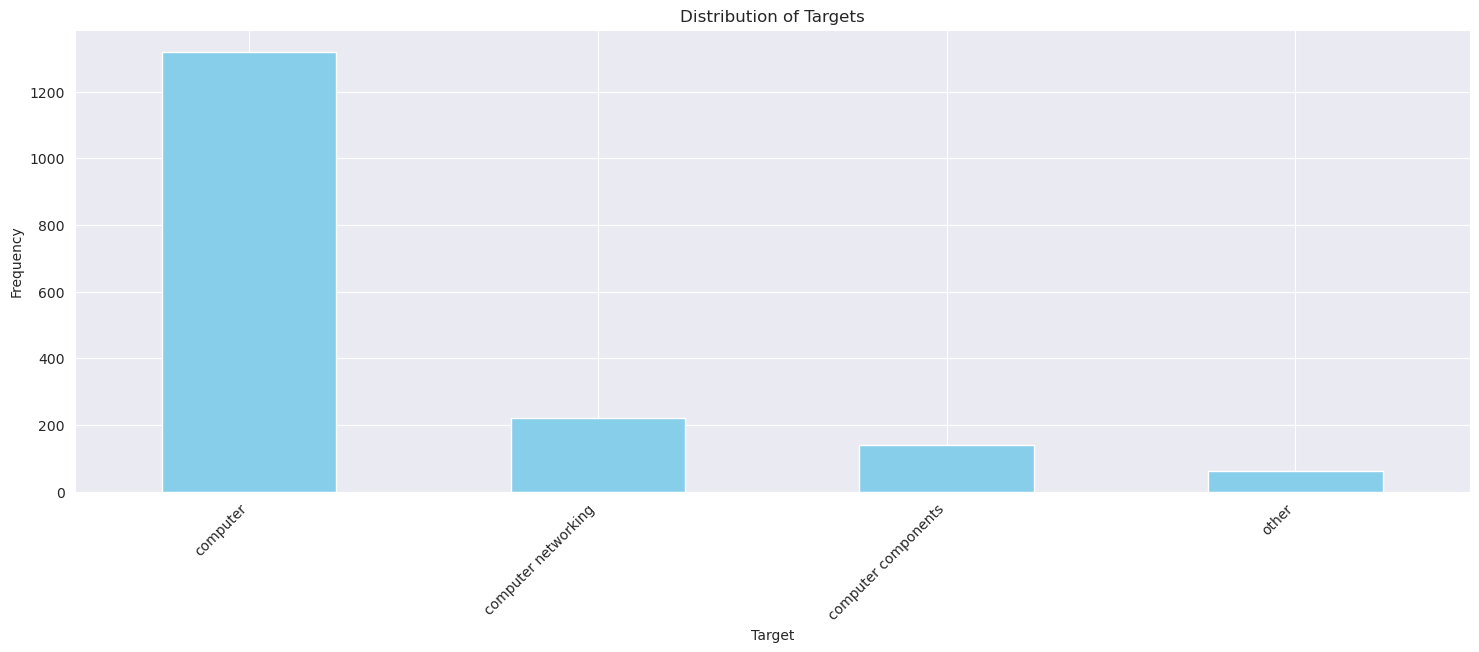

In [18]:
class_freq = Counter([item[0] for item in threat_tweets['target']])

print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Target Frequencies:
('computer',): 1292
('computer networking',): 164
('computer components',): 140
('other',): 61
('computer networking', 'computer'): 55
('computer', 'computer components'): 28
('computer networking', 'computer components'): 1


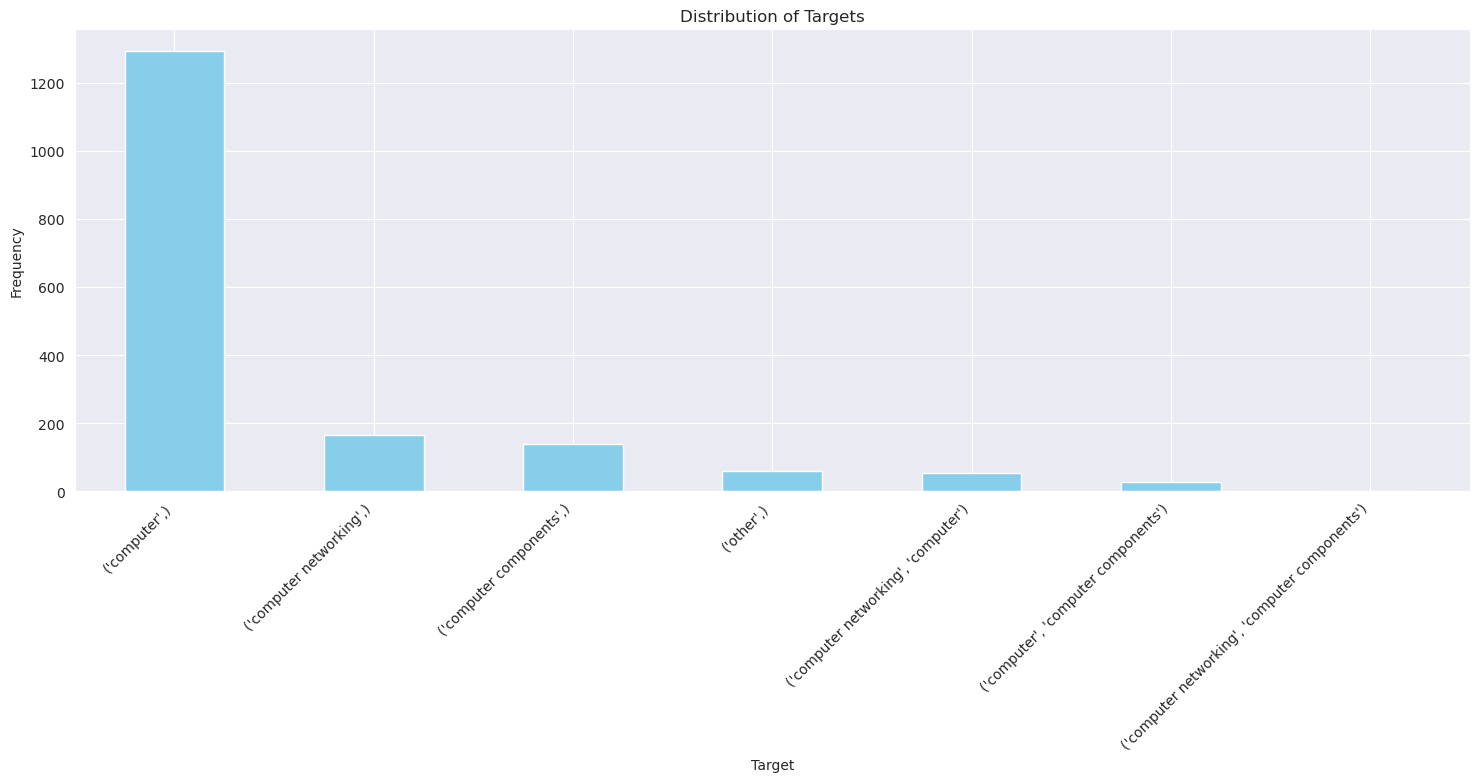

In [19]:
target_freq = Counter(tuple(item) for item in threat_tweets['target'])

print("Target Frequencies:")
for target, freq in target_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))

(pd.Series(data={str(k): v for k, v in target_freq.items()})
 .sort_values(ascending=False)
 .plot(kind='bar', color='skyblue'))

plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [20]:
# Multi-Label Analysis
multi_label_counts = threat_tweets['target'].apply(func=lambda x: len(x) > 1).sum()
print(f"Number of tweets with multiple targets: {multi_label_counts}")

Number of tweets with multiple targets: 84


In [21]:
# Text-Target Relationship
target_text_pairs = [
    (target, text)
    for targets, text in zip(threat_tweets['target'], threat_tweets['text'])
    for target in targets
]

target_text_df = pd.DataFrame(data=target_text_pairs, columns=['target', 'text'])

for target in class_freq:
    target_texts = target_text_df[target_text_df['target'].apply(func=lambda x: target in x)]['text']
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(raw_documents=target_texts)
    word_freq = pd.Series(data=word_counts.sum(axis=0).A1, index=vectorizer.get_feature_names_out())
    print(f"Top 10 words for target '{target}':")
    print(word_freq.nlargest(10))

Top 10 words for target 'computer':
vulnerability    627
android          265
phone            223
major            215
manufacturer     211
attack           208
ddos             168
ransomware       168
new              139
hacker           132
dtype: int64
Top 10 words for target 'computer networking':
vulnerability    92
router           52
huawei           37
dlink            36
tor              35
botnet           34
iot              30
hakai            29
realtek          27
browser          26
dtype: int64
Top 10 words for target 'computer components':
attack           28
denial           26
service          26
vulnerability    26
look             23
case             22
evolution        22
interesting      22
study            22
293              19
dtype: int64
Top 10 words for target 'other':
vulnerability    19
scanner          14
little            8
file              7
ddosangriffe      6
denial            6
dns               6
loadbalancing     6
nmap              6
poc     

## 5. Feature Engineering

In [22]:
# Find valid targets (with frequency ≥ 5)
valid_targets = {target for target, freq in target_freq.items() if freq >= 5}

# Filter the DataFrame to keep only valid targets
filtered_df = threat_tweets[threat_tweets['target'].apply(lambda x: tuple(x) in valid_targets)]

# Reset the index (optional)
filtered_df = filtered_df.reset_index(drop=True)

# Print the updated target frequencies
updated_target_freq = Counter(tuple(item) for item in filtered_df['target'])
print("Updated Target Frequencies:")
for target, freq in updated_target_freq.most_common():
    print(f"{target}: {freq}")

Updated Target Frequencies:
('computer',): 1292
('computer networking',): 164
('computer components',): 140
('other',): 61
('computer networking', 'computer'): 55
('computer', 'computer components'): 28


Preprocess the `text` column into embeddings

In [23]:
def load_word2vec_dict(model_path: Path, embedding_dim: int) -> dict[Union[str, list[str]], np.ndarray[Any, np.dtype]]:
    embeddings_dict = {}

    f = open(model_path, 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[:-embedding_dim]

        if type(word) is list:
            word = ' '.join(word)

        vector = asarray([float(val) for val in values[-embedding_dim:]])
        embeddings_dict[word] = vector
    f.close()

    return embeddings_dict


def preprocess_texts(list_str, model_path, embedding_dim):
    if embedding_dim is None:
        return tokenizer_transform(
            x=list_str,
            embedder_addr=model_path,
            preprocessing_list=[replace_text_components, clean_text]
        )

    word2vec_dict = load_word2vec_dict(
        model_path=model_path,
        embedding_dim=embedding_dim
    )
    list_embedded_str = np.zeros((len(list_str), embedding_dim))

    for i, text in enumerate(list_str):
        tokens = re.findall(r'\w+|[{}]'.format(re.escape(string.punctuation)), text)

        for token in tokens:
            try:
                list_embedded_str[i] += word2vec_dict[token.lower()]
            except KeyError:
                continue

    return list_embedded_str


texts = filtered_df['text']
x = preprocess_texts(
    list_str=texts,
    model_path='sentence-transformers/all-mpnet-base-v2',
    embedding_dim=None
)
#X = preprocess_texts(list_str=filtered_df['text'], model_path=GLOVE_6B_300D_TXT, embedding_dim=300)

Convert the `target` column into a binary multi-label matrix

In [24]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y=filtered_df['target'])

Perform pruning and subsampling of the dataset to remove infrequent targets

In [25]:
X_pst, y_pst, label_map_pst, _ = prune_and_subsample(
    x=x,
    y=y,
    pruning_threshold=np.median(np.array(list(target_freq.values()))) * .25,
    max_sub_samples=round(np.median(np.array(list(target_freq.values()))) * .25)
)

Create a dictionary that maps label indices to unique label sets

In [26]:
unique_label_sets, y_lp = np.unique(ar=y, axis=0, return_inverse=True)
label_map_lp = {i: tuple(lbl_set) for i, lbl_set in enumerate(unique_label_sets)}

In [27]:
#smote = SMOTE(random_state=42)
#X, y_lp = smote.fit_resample(X, y_lp)
#y = np.array(unique_label_sets[y_lp])
#print(f"{X.shape}, {len(y_lp)}")

## 6. Model Training

In [28]:
# BR, CLR, CC, CDN, MBR, LP
X_train, X_val, y_train, y_val, y_train_lp, y_val_lp = train_test_split(
    x, y, y_lp,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_lp
)

print(
    f"{'Training:':<15}\tX = {str(X_train.shape[0]) + ' × ' + str(X_train.shape[1]):<15}\ty = {str(y_train.shape[0]) + ' × ' + str(y_train.shape[1]):<15}")
print(
    f"{'Validation:':<15}\tX = {str(X_val.shape[0]) + ' × ' + str(X_val.shape[1]):<15}\ty = {str(y_val.shape[0]) + ' × ' + str(y_val.shape[1]):<15}")

Training:      	X = 1392 × 768     	y = 1392 × 4       
Validation:    	X = 348 × 768      	y = 348 × 4        


In [29]:
# PSt
X_train_pst, X_val_pst, y_train_pst, y_val_pst = train_test_split(
    X_pst, y_pst,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_pst
)
print(
    f"{'Training:':<15}\tX = {str(X_train_pst.shape[0]) + ' × ' + str(X_train_pst.shape[1]):<15}\ty = {str(len(y_train_pst)):<15}")
print(
    f"{'Validation:':<15}\tX = {str(X_val_pst.shape[0]) + ' × ' + str(X_val_pst.shape[1]):<15}\ty = {str((len(y_val_pst))):<15}")

Training:      	X = 1392 × 768     	y = 1392           
Validation:    	X = 348 × 768      	y = 348            


### 4.1. Binary Problems


#### 4.1.1. BR (Binary Relevance)


In [30]:
if RETRAIN:
    for k in tqdm(BASE_CLASSIFIERS.keys()):
        br[k] = OneVsRestClassifier(estimator=BASE_CLASSIFIERS[k]).fit(X=X_train, y=y_train)

100%|██████████| 3/3 [00:12<00:00,  4.02s/it]


#### 4.1.2. CLR (Calibrated Label Ranking)


In [31]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = CalibratedLabelRankClassifier(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        clr[k] = model.fit(
            x=X_train,
            y=[list(mlb.classes_[np.where(row == 1)[0]]) for row in y_train]
        )

100%|██████████| 3/3 [00:27<00:00,  9.12s/it]


#### 4.1.3. CC (Classifier Chains)


In [32]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ChainOfClassifiers(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        cc[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 3/3 [00:16<00:00,  5.44s/it]


### 4.2. Multi-class Problems



#### 4.2.1. LP (Label Powerset)


In [33]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_lp,
            random_state=RANDOM_STATE
        )

        lp[k] = model.fit(
            x=X_train,
            y=y_train_lp
        )

100%|██████████| 3/3 [00:09<00:00,  3.23s/it]


#### 4.2.2. PSt (Pruned Sets)


In [34]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_pst,
            random_state=RANDOM_STATE
        )

        pst[k] = model.fit(
            x=X_train_pst,
            y=y_train_pst
        )

100%|██████████| 3/3 [00:09<00:00,  3.25s/it]


### 4.3. Ensembles


#### 4.3.1. CDN (Conditional Dependency Network)


In [35]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ConditionalDependencyNetwork(
            classifier=v,
            num_iterations=100,
            burn_in=10
        )

        cdn[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 3/3 [00:10<00:00,  3.36s/it]


#### 4.3.2. MBR (Meta-Binary Relevance)


In [36]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = MetaBinaryRelevance(
            classifier=v,
            use_cross_val=True,
            n_splits=5
        )

        mbr[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 3/3 [01:09<00:00, 23.19s/it]


## 7. Model Evaluation

In [37]:
performances = {}

### 7.1. Binary Problems



#### 7.1.1. BR (Binary Relevance)


In [38]:
performances['BR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=br,
    classes=mlb.classes_
)

In [39]:
y_val_hat = performances['BR']['Model'].predict(X_val)
print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                     precision    recall  f1-score   support

           computer       0.88      1.00      0.94       275
computer components       1.00      0.41      0.58        34
computer networking       1.00      0.52      0.69        44
              other       1.00      0.33      0.50        12

          micro avg       0.89      0.86      0.88       365
          macro avg       0.97      0.57      0.68       365
       weighted avg       0.91      0.86      0.86       365
        samples avg       0.89      0.87      0.88       365

Accuracy:	0.8563
AUC:	0.7197


#### 7.1.2. CLR (Calibrated Label Ranking)


In [40]:
performances['CLR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=clr,
    classes=mlb.classes_
)

In [41]:
y_val_hat = performances['CLR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                     precision    recall  f1-score   support

           computer       0.88      0.99      0.93       275
computer components       1.00      0.41      0.58        34
computer networking       1.00      0.64      0.78        44
              other       1.00      0.33      0.50        12

          micro avg       0.89      0.87      0.88       365
          macro avg       0.97      0.59      0.70       365
       weighted avg       0.91      0.87      0.87       365
        samples avg       0.89      0.88      0.89       365

Accuracy:	0.8621
AUC:	0.7317


#### 7.1.3. CC (Classifier Chains)


In [42]:
performances['CC'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cc,
    classes=mlb.classes_
)

In [43]:
y_val_hat = performances['CC']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                     precision    recall  f1-score   support

           computer       0.91      0.96      0.93       275
computer components       0.73      0.47      0.57        34
computer networking       0.92      0.75      0.82        44
              other       0.83      0.42      0.56        12

          micro avg       0.90      0.87      0.88       365
          macro avg       0.85      0.65      0.72       365
       weighted avg       0.89      0.87      0.88       365
        samples avg       0.90      0.88      0.89       365

Accuracy:	0.8678
AUC:	0.7761


### 7.2. Multi-class Problems




#### 7.2.1. LP (Label Powerset)



In [44]:
performances['LP'] = assess_models(
    x=X_val,
    y=np.array([list(label_map_lp[yp]) for yp in y_val_lp]),
    technique=lp,
    classes=mlb.classes_
)

In [45]:
y_val_hat = performances['LP']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                     precision    recall  f1-score   support

           computer       0.90      0.97      0.93       275
computer components       0.84      0.47      0.60        34
computer networking       0.97      0.70      0.82        44
              other       1.00      0.33      0.50        12

          micro avg       0.90      0.87      0.89       365
          macro avg       0.93      0.62      0.71       365
       weighted avg       0.91      0.87      0.87       365
        samples avg       0.90      0.89      0.89       365

Accuracy:	0.8678
AUC:	0.7569


#### 7.2.2. PSt (Pruned Sets)


In [46]:
performances['PST'] = assess_models(
    x=X_val_pst,
    y=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    technique=pst,
    classes=mlb.classes_
)

In [47]:
y_val_hat = performances['PST']['Model'].predict(X_val_pst)

print(classification_report(
    y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(
    f"Accuracy:\t{accuracy_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_pred=y_val_hat):.4f}")
try:
    print(
        f"AUC:\t{roc_auc_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_score=y_val_hat):.4f}")
except ValueError:
    print(f"AUC:\tNot defined")

                     precision    recall  f1-score   support

           computer       0.88      0.99      0.93       275
computer components       1.00      0.62      0.76        34
computer networking       0.96      0.50      0.66        44
              other       1.00      0.42      0.59        12

          micro avg       0.90      0.87      0.88       365
          macro avg       0.96      0.63      0.73       365
       weighted avg       0.91      0.87      0.87       365
        samples avg       0.90      0.88      0.89       365

Accuracy:	0.8621
AUC:	0.7529


### 7.3. Ensembles


#### 7.3.1. CDN (Conditional Dependency Network)


In [48]:
performances['CDN'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cdn,
    classes=mlb.classes_
)

In [49]:
y_val_hat = performances['CDN']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                     precision    recall  f1-score   support

           computer       0.87      0.94      0.91       275
computer components       0.77      0.29      0.43        34
computer networking       0.78      0.66      0.72        44
              other       0.33      0.17      0.22        12

          micro avg       0.85      0.82      0.84       365
          macro avg       0.69      0.51      0.57       365
       weighted avg       0.84      0.82      0.82       365
        samples avg       0.85      0.84      0.84       365

Accuracy:	0.8132
AUC:	0.6879


#### 7.3.2. MBR (Meta-Binary Relevance)


In [50]:
performances['MBR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=mbr,
    classes=mlb.classes_
)

In [51]:
y_val_hat = performances['MBR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                     precision    recall  f1-score   support

           computer       0.91      0.96      0.93       275
computer components       0.88      0.65      0.75        34
computer networking       0.95      0.80      0.86        44
              other       1.00      0.42      0.59        12

          micro avg       0.92      0.89      0.90       365
          macro avg       0.93      0.70      0.78       365
       weighted avg       0.92      0.89      0.90       365
        samples avg       0.90      0.90      0.90       365

Accuracy:	0.8592
AUC:	0.8071


## 8. Summary


In [52]:
performances = pd.DataFrame(performances).T
performances

,Accuracy,Classifier,Model,Precision example-based,Recall example-based,F1 example-based,Hamming loss,Micro precision,Micro recall,Micro F1,Macro precision,Macro recall,Macro F1,Coverage,Classification
BR,0.856322,random_forest,OneVsRestClassifier(estimator=RandomForestClas...,0.890805,0.873563,0.87931,0.0625,0.894886,0.863014,0.878661,0.970257,0.566047,0.676264,1.445402,precision recall f1-s...
CLR,0.862069,random_forest,CalibratedLabelRankClassifier(classes=array(['...,0.893678,0.882184,0.885057,0.060345,0.893557,0.873973,0.883657,0.969453,0.593547,0.698213,1.422414,precision recall f1-s...
CC,0.867816,xgb,"ChainOfClassifiers(classes=array(['computer', ...",0.896552,0.882184,0.886973,0.059626,0.898305,0.871233,0.884562,0.846904,0.649314,0.721624,1.413793,precision recall f1-s...
LP,0.867816,xgb,LabelPowersetClassifier(classifier=XGBClassifi...,0.902299,0.885057,0.890805,0.05819,0.903409,0.871233,0.887029,0.927461,0.619844,0.713282,1.408046,precision recall f1-s...
PST,0.862069,xgb,LabelPowersetClassifier(classifier=XGBClassifi...,0.896552,0.883621,0.886973,0.059626,0.896067,0.873973,0.884882,0.959814,0.629942,0.734965,1.41954,precision recall f1-s...
CDN,0.836207,xgb,ConditionalDependencyNetwork(classifier=XGBCla...,0.876437,0.856322,0.863027,0.072557,0.875,0.843836,0.859135,0.798918,0.57484,0.647786,1.5,precision recall f1-s...
MBR,0.859195,xgb,MetaBinaryRelevance(classifier=XGBClassifier(b...,0.902299,0.902299,0.89751,0.050287,0.915493,0.890411,0.902778,0.934785,0.703886,0.783119,1.382184,precision recall f1-s...


In [53]:
if OVERWRITE:
    joblib.dump(br, BR_PKL, compress=9)
    joblib.dump(clr, CLR_PKL, compress=9)
    joblib.dump(cc, CC_PKL, compress=9)
    joblib.dump(lp, LP_PKL, compress=9)
    joblib.dump(pst, PST_PKL, compress=9)
    joblib.dump(cdn, CDN_PKL, compress=9)
    joblib.dump(mbr, MBR_PKL, compress=9)

In [53]:
max_f1_score = 0.
optimal_model = None
for _, performance in performances.iterrows():
    if max_f1_score < performance['Macro F1']:
        max_f1_score = performance['Macro F1']
        optimal_model = performance['Model']

if OVERWRITE:
    joblib.dump(optimal_model, HARDWARE_PKL, compress=9)

In [55]:
z = joblib.load(filename=HARDWARE_PKL)
type(z)

utils.MetaBinaryRelevance